In [1]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16

def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_vgg16_unet(input_shape):
    """ Input """
    inputs = Input(input_shape)

    """ Pre-trained VGG16 Model """
    vgg16 = VGG16(include_top=False, weights='imagenet', input_tensor=inputs)

    """ Encoder """
    s1 = vgg16.get_layer("block1_conv2").output         ## (512 x 512)
    s2 = vgg16.get_layer("block2_conv2").output         ## (256 x 256)
    s3 = vgg16.get_layer("block3_conv3").output         ## (128 x 128)
    s4 = vgg16.get_layer("block4_conv3").output         ## (64 x 64)

    """ Bridge """
    b1 = vgg16.get_layer("block5_conv3").output         ## (32 x 32)

    """ Decoder """
    d1 = decoder_block(b1, s4, 512)                     ## (64 x 64)
    d2 = decoder_block(d1, s3, 256)                     ## (128 x 128)
    d3 = decoder_block(d2, s2, 128)                     ## (256 x 256)
    d4 = decoder_block(d3, s1, 64)                      ## (512 x 512)

    """ Output """
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="VGG16_U-Net")
    return model

# if __name__ == "__main__":
input_shape = (352, 352, 3)
model = build_vgg16_unet(input_shape)
# model.summary()

2021-09-20 19:33:01.310777: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-09-20 19:33:01.791490: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8145 MB memory:  -> device: 0, name: A100-SXM4-40GB MIG 2g.10gb, pci bus id: 0000:07:00.0, compute capability: 8.0


In [2]:
# !pip install opencv-python-headless
# !pip list
# !pip install opencv-python

In [3]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import glob
import cv2
import pickle
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D
import os
from tensorflow.keras.metrics import MeanIoU

In [20]:
#Resizing images is optional, CNNs are ok with large images
SIZE_X = 352 #Resize images (height  = X, width = Y)
SIZE_Y = 352

#Capture training image info as a list
train_images = []

for directory_path in glob.glob("data/thermal"):
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)       
        img = cv2.resize(img, (SIZE_Y, SIZE_X))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        train_images.append(img)
        #train_labels.append(label)
#Convert list to array for machine learning processing        
train_images = np.array(train_images)

In [5]:
len(train_images)
# train_images=train_images[:10]

821

In [6]:
#Capture mask/label info as a list
train_masks = [] 
for directory_path in glob.glob("data/GT"):
    for mask_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        mask = cv2.imread(mask_path, 0)       
        mask = cv2.resize(mask, (SIZE_Y, SIZE_X))
        #mask = cv2.cvtColor(mask, cv2.COLOR_RGB2BGR)
        train_masks.append(mask)
        #train_labels.append(label)
#Convert list to array for machine learning processing          
train_masks = np.array(train_masks)

In [7]:
len(train_masks)
# train_masks=train_masks[:10]

821

In [8]:
# len(train_masks)

In [21]:

# X_train = train_images
# y_train = 
train_images=train_images/255.
train_masks=train_masks/255.
# y_train = np.expand_dims(y_train, axis=3) #May not be necessary.. leftover from previous code 

In [10]:
# len(X_train)

In [22]:
(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)=(352,352,3)
input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

In [23]:
sgd = SGD(learning_rate=0.00001)

In [13]:
# from sklearn.metrics import confusion_matrix  
# # import numpy as np

# def compute_iou(y_pred, y_true):
#  # ytrue, ypred is a flatten vector
# #      print(type(y_pred),type(y_true))
# #      plt.imshow(y_pred)
#      y_pred = y_pred.flatten()
#      y_true = y_true.flatten()
#      current = confusion_matrix(y_true, y_pred, labels=[0, 1])
#  # compute mean iou
#      intersection = np.diag(current)
#      ground_truth_set = current.sum(axis=1)
#      predicted_set = current.sum(axis=0)
#      union = ground_truth_set + predicted_set - intersection
#      IoU = intersection / union.astype(np.float32)
#      return np.mean(IoU)

In [14]:
# compute_iou(y_test[0],y_test[0])

In [24]:
# from tensorflow.keras.metrics import MeanIoU, BinaryAccuracy
# model.summary()#. = Model(inputs=visible, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# model.compile(optimizer='sgd', loss='mse', metrics=[BinaryAccuracy()])
# mIOU=MeanIoU(num_classes=2)
# _ = mIOU.update_state([0, 0, 1, 1], [0, 0, 1, 1])
# model.compile(optimizer='sgd',loss='mse',metrics=[compute_iou])
# import tensorflow_addons as tfa
# model.compile('sgd', loss=tfa.losses.GIoULoss())
# model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
# model.compile(optimizer='adam', loss='mse', metrics=[IoU])
# model.compile(optimizer='adam',loss=compute_iou)
# model.run_eagerly = False

In [16]:
# import tensorflow as tf
# tf.test.gpu_device_name

In [17]:
# !pip install tf_nightly

In [25]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_images,train_masks, test_size = 0.25, random_state = 0)

In [39]:
history= model.fit(X_train, y_train, 
                    batch_size = 1, 
                    verbose=1, 
                    epochs=20, 
                    validation_data=(X_test, y_test), 
                    shuffle=False)
# history=model.lo

Epoch 1/20
615/615 [==============================] - 40s 64ms/step - loss: 0.1799 - accuracy: 0.9191 - val_loss: 0.4010 - val_accuracy: 0.8027
Epoch 2/20
615/615 [==============================] - 39s 64ms/step - loss: 0.1791 - accuracy: 0.9199 - val_loss: 0.3340 - val_accuracy: 0.8389
Epoch 3/20
615/615 [==============================] - 39s 64ms/step - loss: 0.1757 - accuracy: 0.9210 - val_loss: 0.3584 - val_accuracy: 0.8155
Epoch 4/20
615/615 [==============================] - 39s 64ms/step - loss: 0.1793 - accuracy: 0.9203 - val_loss: 0.3725 - val_accuracy: 0.8094
Epoch 5/20
615/615 [==============================] - 39s 64ms/step - loss: 0.1714 - accuracy: 0.9223 - val_loss: 0.2999 - val_accuracy: 0.8646
Epoch 6/20
615/615 [==============================] - 39s 64ms/step - loss: 0.1683 - accuracy: 0.9234 - val_loss: 0.3942 - val_accuracy: 0.8013
Epoch 7/20
615/615 [==============================] - 39s 64ms/step - loss: 0.1670 - accuracy: 0.9239 - val_loss: 0.3322 - val_accuracy:

AttributeError: 'Functional' object has no attribute 'lo'

In [ ]:
# len(X_train)
# len(y_train)

In [ ]:
# len(y_train)

In [45]:
# len(X_test)
# len(y_test)
# history['accuracy']


In [40]:
# X_train[0][0]
model.save('models/thermal_gt_vgg16_2.hdf5')

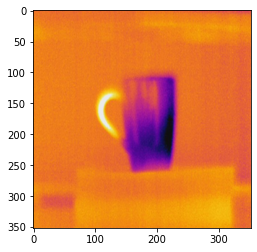

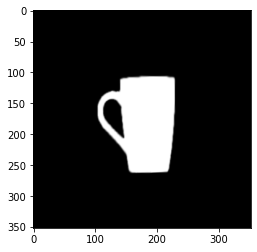

In [41]:
img = cv2.imread("data/RGB/201.jpg", cv2.IMREAD_COLOR)   
img = cv2.resize(img, (SIZE_Y, SIZE_X))
# cv2.imshow(img,"id")
mask = cv2.imread("data/GT/201.jpg", 0)       
mask = cv2.resize(mask, (SIZE_Y, SIZE_X))

import matplotlib.pyplot as plt
plt.imshow(X_test[3])
plt.show();
plt.imshow(y_test[3], cmap='gray')
plt.show()

In [ ]:
# zz=model.predict(img)

In [ ]:
# x.shape

In [35]:
# # model.predict(x)
# history.history

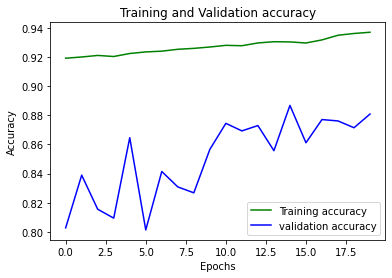

In [42]:
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
epochs = history.epoch
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

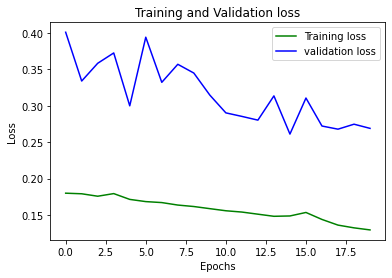

In [43]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = history.epoch
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [53]:
# x_input=img/255
x=np.array([X_test[3]])
y_output=model.predict(x)

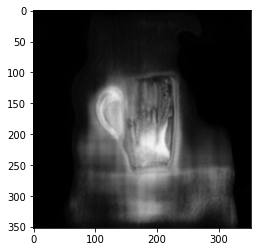

In [54]:
plt.imshow(y_output[0],cmap='gray')

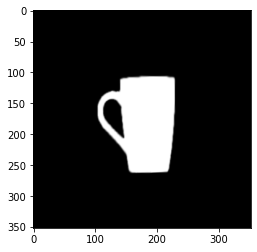

In [55]:
plt.imshow(y_test[3],cmap='gray')

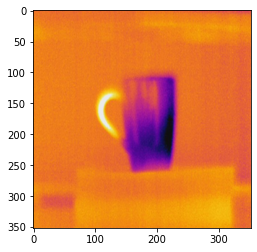

In [56]:
plt.imshow(X_test[3])